In [128]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy, scipy as sklearn, librosa, urllib
import librosa.display
from IPython.display import Audio
import json 
import seaborn as sns
from sklearn.cluster import KMeans
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import keras
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from os import path

from itertools import cycle
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, silhouette_score,roc_auc_score, precision_recall_fscore_support
from tqdm import tqdm
import opensmile


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import regularizers
from joblib import dump, load

from tensorflow.keras.datasets import mnist


In [129]:
import tensorflow as tf

# Loss personalizzata
def custom_loss(y_true, y_pred):
    
    cl = y_true[:, -2]        # Ultima colonna come etichetta di classe
    ori = y_true[:, :-2]      # Restante parte come dati originali

    class_labels = cl[0]
    original_data = ori
    # class_labels = tf.where(class_labels == 2, 1, class_labels)
    # class_labels = tf.where(class_labels == 8, 0, class_labels)
    class_labels = tf.where(class_labels > 3, 1.0, 0.0)
    # tf.print((class_labels))
    return contrastive_loss(original_data, y_pred, class_labels, alpha=1)
def contrastive_loss(y_true, y_pred, class_labels, alpha):
    """
    Funzione di loss contrastiva che:
    - Minimizza l'errore di ricostruzione per la classe target (class_labels = 1).
    - Massimizza l'errore di ricostruzione per le altre classi (class_labels = 0).
    """
    # Calcolo dell'errore di ricostruzione
    # print(y_true)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    classes = tf.math.bincount(class_labels)
    target = classes[0]
    non_target = classes[1]
    total = tf.add(target, non_target)
    target_div = 1 - tf.divide(target, total)
    non_target_div = 1 - tf.divide(non_target, total)
    # tf.print(non_target_div, target_div)

    reconstruction_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False) 
    # tf.print(tf.size(reconstruction_loss))
    # tf.print(tf.math.reduce_max(reconstruction_loss))
    target_loss = class_labels * (reconstruction_loss) 
    # target_div = tf.cast(target_div, target_loss.dtype)
    # target_loss = tf.math.multiply(target_loss,target_div)

    # Penalità per le classi non target (class_labels = 0): amplificata con il parametro alpha
    non_target_loss = (1.0 - class_labels) * tf.square(tf.maximum(alpha - reconstruction_loss, 0.0)) 

    # non_target_div = tf.cast(target_div, non_target_loss.dtype)
    # non_target_loss = tf.math.multiply(non_target_loss, non_target_div)
    loss_tot = target_loss + non_target_loss
    return tf.reduce_mean(loss_tot)


In [157]:
import tensorflow as tf

# Loss personalizzata
def custom_loss_circle(y_true, y_pred):
    
    cl = y_true[:, -2:]        # Ultima colonna come etichetta di classe
    ori = y_true[:, :-2]      # Restante parte come dati originali

    original_data = cl
    cl = cl[0]
    # class_labels = tf.where(class_labels == 2, 1, class_labels)
    # class_labels = tf.where(class_labels == 8, 0, class_labels)
    cl = tf.where(cl > 3, 1.0, 0.0)
    # tf.print((class_labels))
    return circle_loss(original_data, y_pred, cl, alpha=1)
def circle_loss(y_true, y_pred, class_labels, alpha):
    """
    Funzione di loss contrastiva che:
    - Minimizza l'errore di ricostruzione per la classe target (class_labels = 1).
    - Massimizza l'errore di ricostruzione per le altre classi (class_labels = 0).
    """

    # tf.print((y_pred.dtype), (y_true.dtype))

    # y_true = tf.cast(y_true, y_pred.dtype)
    # tf.print(tf.shape(class_labels))
    # Calculate the reconstruction loss
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)

    # tf.print("re:" ,reconstruction_loss)
    # Calculate the distance from the predicted points to the circle center (y_true)
    distance = tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true), axis=-1))
    # tf.print("d", distance)
   
    # Calculate the penalty for points outside the circle
    outside_circle_penalty = tf.maximum(distance - 1, 0.0)
    # tf.print("ocp :", outside_circle_penalty)
    class_labels = tf.where(outside_circle_penalty > 1, 1.0, 0.0)
    
    total_loss = class_labels * outside_circle_penalty
    
    # # Apply the penalty only for class_labels == 1
    # total_loss = tf.where(class_labels == 1, reconstruction_loss + alpha * outside_circle_penalty, reconstruction_loss)
    # # Apply the MSE to let y_pred be near the circle with radius 1 if class_labels is 1
    # mse_near_circle = tf.square(distance - 1)
    # total_loss = tf.where(class_labels == 1, mse_near_circle, total_loss)
    # tf.print("tl:", total_loss)
    return tf.reduce_mean(total_loss)


In [158]:
def build_autoencoder(neurons_in=28, act_function="sigmoid", optimizer="adam", hidden_layers=0):
    # Input layer
    input_layer = keras.layers.Input(shape=(88,))

    l1_encoded = keras.layers.Dense(28, activation='relu', name='l1')(input_layer)
    # Bottleneck layer
    encoded = keras.layers.Dense(neurons_in, activation='relu', name='bottleneck')(l1_encoded)

    l1_decoded = keras.layers.Dense(28, activation='relu', name='l2')(encoded)
    # Output layer
    decoded = keras.layers.Dense(88, activation=act_function, name='decoded')(l1_decoded)

    # Create the model
    autoencoder = keras.Model(inputs=input_layer, outputs=[decoded,encoded])
    autoencoder.compile(loss=["binary_crossentropy",custom_loss_circle], optimizer=optimizer, loss_weights=[1, 0.4])

    return autoencoder

def train_autoencoder(emotion,data_t,data_v, index):

    callbacks = [
        keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=40,
        verbose=0,
        mode="auto",
        restore_best_weights=True
        )
    ]
    ae = build_autoencoder(2,"sigmoid","adam",0)
    _X_train = data_t[index]
    _X_val = data_v[index]

    # _X_train
    __X_train = np.hstack(_X_train)
    __X_val = np.hstack(_X_val)

    # print(_X_train[0].shape)
    # print(__X_train.shape)
    history = ae.fit(_X_train[0],_X_train,
            validation_data = (_X_val[0],_X_val),
            epochs=5000,
            batch_size=128,
            verbose=0,
            callbacks = callbacks)


    return ae


def get_representations_re(autoencoder_to_test, encoders, test):

    lab = []

    res = (encoders[autoencoder_to_test].predict(test[autoencoder_to_test], verbose = False))
        # print(len(test[i]))


    features = np.array(res)
    return features


def mean_diff(arrays):
    max_length = max(arr.shape[0] for arr in arrays)

    padded_arrays = []
    for arr in arrays:
        pad_length = max_length - arr.shape[0]
        padded = np.pad(arr, ((0, pad_length), (0, 0)), mode='constant', constant_values=np.nan)
        padded_arrays.append(padded)

    stacked_arrays = np.stack(padded_arrays, axis=0)  
    averaged_array = np.nanmean(stacked_arrays, axis=0)
    return stacked_arrays, averaged_array
def get_emo_df(emotion, dataframe):
    emo = []
    tot = 0
    print(f"Processing {emotion} ...")
    for id, name in zip(dataframe["filename"],dataframe["label"]):
        if f"{emotion}" in name:
            emo.append(id)
            tot += 1
    print(f"Processed {tot} file for {emotion}")


    mask = dataframe['filename'].isin(emo)
    emo_df = dataframe[mask].reset_index()
    emo_df = emo_df.drop(['index'], axis=1)
    return emo_df
def get_data(df,seed):
    X = pd.concat(df["features"].tolist(), ignore_index=True)
    _X= (X-X.min())/(X.max()-X.min())
    


    X_train, X_test = train_test_split(_X, test_size=.2, random_state=seed)
    X_train, X_val = train_test_split(X_train, test_size=.1, random_state=seed)
    # print(len(X_train), len(X_val), len(X_test))
    return X_train, X_val, X_test


from sklearn.metrics import confusion_matrix
def obtain_cm(y_true, y_pred, labels):
    cm = confusion_matrix(y_true,y_pred)

    g = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
    g.xaxis.set_ticklabels(labels, rotation = 15,fontsize=12)
    g.yaxis.set_ticklabels(labels, rotation = 30,fontsize=12)
    g.set_xlabel("Predicted Label", fontsize=14)
    g.set_ylabel("True Label", fontsize = 14)

    plt.tight_layout()
    plt.show()
    # g.figure.savefig(name)

# g.set_title(data, fontsize = 18)


from sklearn.metrics import mean_squared_error

def obtain_predictions(test, autoencoders):
    y_true = []

    y_pred = []
    errors = []
    _test = []
    for n in range(len(test)):
        _test.append(test[n].to_numpy())
    for n in tqdm(range(len(df))):
        X_test = _test[n]
        cls = []

        for i in (range(len(X_test))):
            _er = []
            for encoder in autoencoders:
            #print(labels[x])
                # _er.append(mean_squared_error(X_test[i],encoder.predict(X_test[i][0].reshape(-1,88), verbose=0).reshape(88,))) #1 output
                _er.append(mean_squared_error(X_test[i],encoder.predict(X_test[i].reshape(-1,88),verbose=0)[0].reshape(88,)))  #2 outputs
                # print(mean_squared_error(X_test[i],encoder.predict(X_test[i].reshape(-1,88), verbose=0).reshape(88,)).shape)
            errors.append(_er)
            y_pred.append(np.argmin(_er))
            y_true.append(n)
    return errors, y_true, y_pred

    #pred.append(cls)
    # print(cls)

In [159]:
clear_df = pd.read_pickle("../utils/data/clear_functional.pkl")
seed = 83
clear_df = pd.read_pickle("../utils/data/clear_functional_emovo.pkl")
seed = 10
# seed = 24

# clear_df = pd.read_pickle("../utils/data/pitch_functional_demos.pkl")
# clear_df = pd.read_pickle("../utils/data/pitch_functional_emovo.pkl")
lab = clear_df["label"].unique()
lab

array(['disgust', 'joy', 'neutrality', 'fear', 'anger', 'surprise',
       'sadness'], dtype=object)

In [160]:
df = []

for i,emotion in enumerate(lab):
    df.append(get_emo_df(emotion,clear_df))
    
    print(f"Processed {len(df[i])} files for {emotion}")

Processing disgust ...
Processed 84 file for disgust
Processed 84 files for disgust
Processing joy ...
Processed 84 file for joy
Processed 84 files for joy
Processing neutrality ...
Processed 84 file for neutrality
Processed 84 files for neutrality
Processing fear ...
Processed 84 file for fear
Processed 84 files for fear
Processing anger ...
Processed 84 file for anger
Processed 84 files for anger
Processing surprise ...
Processed 84 file for surprise
Processed 84 files for surprise
Processing sadness ...
Processed 83 file for sadness
Processed 83 files for sadness


In [161]:
train = []
val = []
test = []
print(seed)
for data in df:
    tr, v, te = get_data(data, seed)
    train.append(tr)
    val.append(v)
    test.append(te)

10


In [162]:
total_train = []
for i in range(len(train)):
    # print(len(train[i].to_numpy()))
    selected_instances = [train[j] for j in range(len(train)) if j != i]
    selected_instances_np = [df.to_numpy() for df in selected_instances]
    stacked_instances = np.vstack(selected_instances_np)
    # print(stacked_instances.shape)
    
    y = np.array([([2, 8]) for _ in range(train[i].to_numpy().shape[0])])
    tr = ([train[i].to_numpy(), y])
    
    y_2 = np.array([([8, 2]) for _ in range(stacked_instances.shape[0])])
    tr_2 = ([stacked_instances, y_2])
    
    combined_tr = (np.vstack((tr[0], tr_2[0])), np.vstack((tr[1], tr_2[1])))
    total_train.append(combined_tr)
    

In [163]:
total_val = []
for i in range(len(val)):
    # print(len(val[i].to_numpy()))
    selected_instances = [val[j] for j in range(len(val)) if j != i]
    selected_instances_np = [df.to_numpy() for df in selected_instances]
    stacked_instances = np.vstack(selected_instances_np)
    # print(stacked_instances.shape)
    
    y = np.array([([2, 8]) for _ in range(val[i].to_numpy().shape[0])])
    tr = ([val[i].to_numpy(), y])
    
    y_2 = np.array([([8, 2]) for _ in range(stacked_instances.shape[0])])
    tr_2 = ([stacked_instances, y_2])
    
    combined_tr = (np.vstack((tr[0], tr_2[0])), np.vstack((tr[1], tr_2[1])))
    total_val.append(combined_tr)
    

In [164]:
from tqdm import tqdm
trained_ae = []
for i,emotion in tqdm(enumerate(lab)):
    trained_ae.append(train_autoencoder(emotion, total_train, total_val, i))


7it [00:54,  7.76s/it]


100%|██████████| 7/7 [00:30<00:00,  4.37s/it]

0.31092436974789917
0.24446830061931643


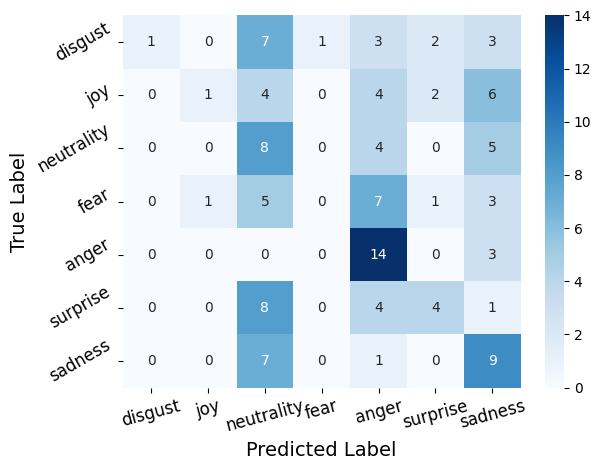

In [165]:
errors, y_true, y_pred = obtain_predictions(test, trained_ae)
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

print(accuracy_score(y_true, y_pred))
print(f1_score(y_true, y_pred, average ="weighted"))

obtain_cm(y_true, y_pred, lab)   

In [166]:
def get_representations(autoencoder_to_test, encoders, test):
    res = []
    lab = []
    for i in range(len(test)):
        res.append(encoders[autoencoder_to_test].predict(test[i], verbose = False)[-1])
        # print(len(test[i]))
        if i == autoencoder_to_test:
            lab.append([1]* len(test[i]))
        else:
            lab.append([0]* len(test[i]))

    features = np.concatenate(res, axis=0)
    labels = np.concatenate(lab, axis=0)
    return features, labels


In [167]:
tot_features = []
tot_labels = []
for i in range(len(trained_ae)):
    features, labels = get_representations(i, trained_ae, test)
    tot_features.append(features)
    tot_labels.append(labels)
# feat = features.reshape(-1,17,2)

In [168]:
tot_target = []
tot_non_target = []

for i in range(len(tot_features)): 

    data_array = tot_features[i]
    mask_array = tot_labels[i]

    tot_target.append(data_array[mask_array == 1])
    tot_non_target.append(data_array[~(mask_array == 1)])

# tot_target = np.array(tot_target)
# tot_non_target = np.array(tot_non_target)
t_features, averaged_1 = mean_diff(tot_target)
nt_features, averaged_2 = mean_diff(tot_non_target)

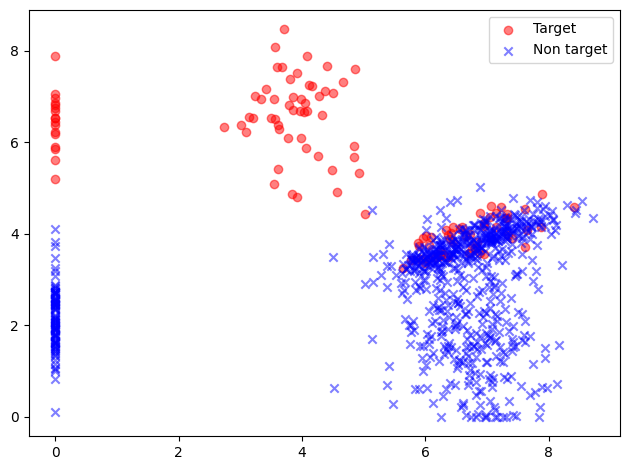

In [169]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

t_features = t_features.reshape(-1,2)
nt_features = nt_features.reshape(-1,2)

ax1.scatter(t_features[:,0], t_features[:,1], marker="o", color="red", alpha=0.5, label="Target")
ax1.scatter(nt_features[:,0], nt_features[:,1], marker="x", color="blue", alpha=0.5, label="Non target")

plt.legend()
plt.tight_layout()
# plt.savefig("DEMOS1.png")